## Section 7: **Fulfilling Requirements 6, 7**
Please note, requirement 6 is implemented in FinalNotebook2_1.ipynb and this is a continuation of this section

# **Requirement 7**: For the modified method(s), repeat the analysis in 4) but only pertaining to the items you choose to improve on as justified in 6). [10%]

Repeating feature and classifier analysis on the proposed modifications model

In [1]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# all modules/libraries needed to run this notebook
import os
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import numpy as np
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import ConcatDataset
import random
import pandas as pd
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from PIL import Image

## Classifier Analysis
### **Experimental Setup**
The analysis will focus on **validation dataset in Batch-1 (seedsegment/test)**, and uses **Accuracy**, **Precision**, **Recall**, **F1 Score** and **AUC Score** to assess how consistent the proposed modification model's classification performance.
- **Transformations Applied:**
  1. *Translation*: Shift image by ±10%, ±20%, ±30%
  2. *Rotation*: Rotate by ±15°, ±30°, ±45°, ±90°, ±180°, ±360°
  3. *Scaling*: Resize image by 0.8×, 1.2×, 1.5×
  4. *Noise*: σ = 0.01, 0.05, 0.1
  5. *Illumination*: brightness change to 0.5 (dimmer than normal), 1.5 (brighter than normal)

  Each transformation is applied individually to measure its isolated effect. GoogleNet retrained on the `augmented_seed_segment_train_googlenet` dataset (from Requirment 6) will be used to compare the **original data's vs. transformed data's classification**.

**Outcome**
This analysis will provide empirical insight into the **classification robustness** of proposed modification GoogleNet when subjected to image transformations.

The following cells loads the validation dataset, feeds it into the modified fine-tuned GoogleNet model. Then, the metrics mentioned above and relevent confusion matrices are outputted.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = googlenet(weights=None, aux_logits=False, num_classes=2)
model.fc = nn.Linear(1024, 2)
model.load_state_dict(torch.load("/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_trained_with_aug_modifications_batch1.pth"), strict=False)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [4]:
# function to evaluate the model on the test set (batch 2 and 3)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, dataloader, test_dataset):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # auc

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if isinstance(outputs, tuple):  # googlenet might return aux output
                outputs = outputs[0]

            # predicted class labels
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # get predicted probabilities for AUC (softmax output)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # get probabilities
            all_probs.extend(probs.cpu().numpy()[:, 1])  # for binary classification, class 1 probabilities

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='binary')
    rec = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)  # AUC score

    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC Score: {auc:.3f}")

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, prec, rec, f1, auc

In [5]:
def add_gaussian_noise(img, mean, std):
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0, 1)  # pixel values remain valid

def add_random_translation(img, max_shift):
    translation = transforms.RandomAffine(degrees=0, translate=(max_shift, max_shift))
    return translation(img)

def add_random_rotation(img, max_angle):
    rotation = transforms.RandomRotation(degrees=max_angle)
    return rotation(img)

def add_random_scaling(img, scale_val):
    scaling = transforms.RandomAffine(degrees=0, scale=(scale_val, scale_val))
    return scaling(img)

def add_random_illumination(img, brightness):
    illumination = transforms.ColorJitter(brightness=brightness)
    return illumination(img)

# creating the different transforms to apply to the train set before training the feature extractor for googlenet
resize_shape = (299, 299)
mean = [0.5035, 0.5035, 0.4966]
std = [0.2686, 0.2735, 0.2766]

def create_transform(augmentation_func=None, **kwargs):
    aug = transforms.Lambda(lambda x: augmentation_func(x, **kwargs)) if augmentation_func else lambda x: x
    return transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.ToTensor(),
        aug,
        transforms.Normalize(mean=mean, std=std)
    ])

original_transform = create_transform(None)

# brightness 0.5 & 1.5
transform_brightness0_5 = create_transform(add_random_illumination, brightness=0.5)
transform_brightness1_5 = create_transform(add_random_illumination, brightness=1.5)

# noise 0.01, 0.05, 0.1
transform_noise0_01 = create_transform(add_gaussian_noise, mean=0.0, std=0.01)
transform_noise0_05 = create_transform(add_gaussian_noise, mean=0.0, std=0.05)
transform_noise0_1  = create_transform(add_gaussian_noise, mean=0.0, std=0.1)

# scale 0.8, 1.2, 1.5
transform_scale0_8 = create_transform(add_random_scaling, scale_val=0.8)
transform_scale1_2 = create_transform(add_random_scaling, scale_val=1.2)
transform_scale1_5 = create_transform(add_random_scaling, scale_val=1.5)

# rotate 15,30,45,90,180,360
transform_rotate15   = create_transform(add_random_rotation, max_angle=15)
transform_rotate30   = create_transform(add_random_rotation, max_angle=30)
transform_rotate45   = create_transform(add_random_rotation, max_angle=45)
transform_rotate90   = create_transform(add_random_rotation, max_angle=90)
transform_rotate180  = create_transform(add_random_rotation, max_angle=180)
transform_rotate360  = create_transform(add_random_rotation, max_angle=360)

# translate 0.1, 0.2, 0.3
transform_translate0_1 = create_transform(add_random_translation, max_shift=0.1)
transform_translate0_2 = create_transform(add_random_translation, max_shift=0.2)
transform_translate0_3 = create_transform(add_random_translation, max_shift=0.3)


Evaluating on validation set (Brightness=0.5):
Accuracy: 0.778
Precision: 0.983
Recall: 0.567
F1 Score: 0.719
AUC Score: 0.917


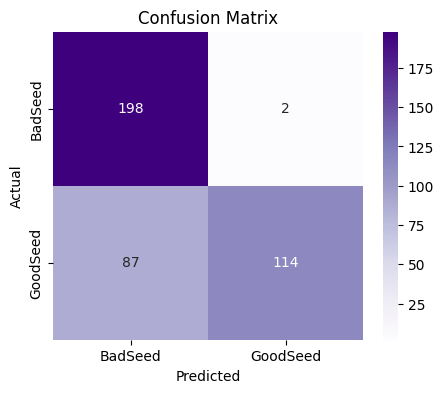

Evaluating on validation set (Brightness=1.5):
Accuracy: 0.713
Precision: 0.989
Recall: 0.433
F1 Score: 0.602
AUC Score: 0.875


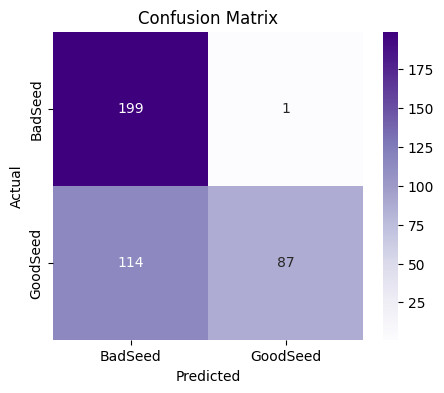

Evaluating on validation set (Noise=0.01):
Accuracy: 0.813
Precision: 1.000
Recall: 0.627
F1 Score: 0.771
AUC Score: 0.960


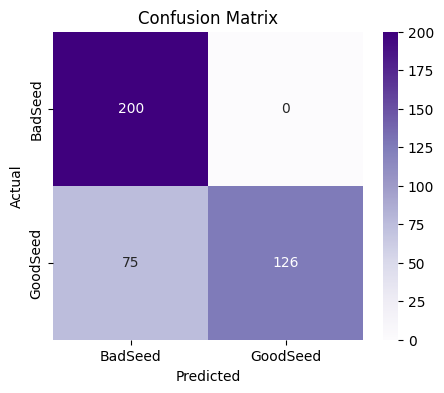

Evaluating on validation set (Noise=0.05):
Accuracy: 0.651
Precision: 1.000
Recall: 0.303
F1 Score: 0.466
AUC Score: 0.925


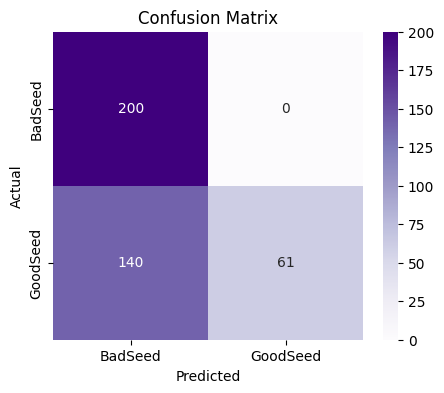

Evaluating on validation set (Noise=0.1):
Accuracy: 0.526
Precision: 1.000
Recall: 0.055
F1 Score: 0.104
AUC Score: 0.815


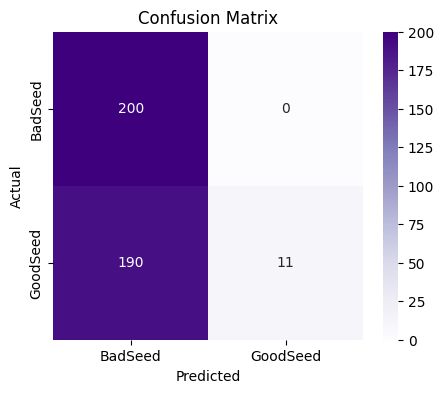

Evaluating on validation set (Scale=0.8):
Accuracy: 0.815
Precision: 0.992
Recall: 0.637
F1 Score: 0.776
AUC Score: 0.950


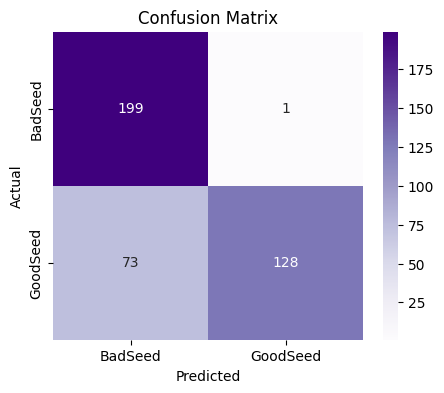

Evaluating on validation set (Scale=1.2):
Accuracy: 0.838
Precision: 1.000
Recall: 0.677
F1 Score: 0.807
AUC Score: 0.963


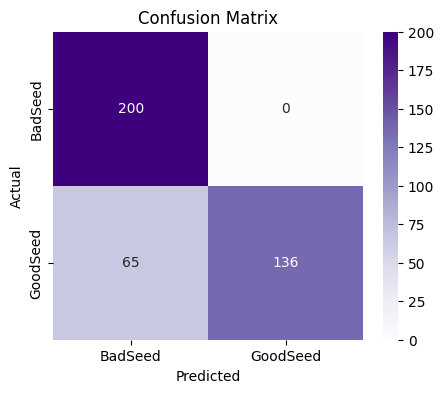

Evaluating on validation set (Scale=1.5):
Accuracy: 0.860
Precision: 1.000
Recall: 0.721
F1 Score: 0.838
AUC Score: 0.967


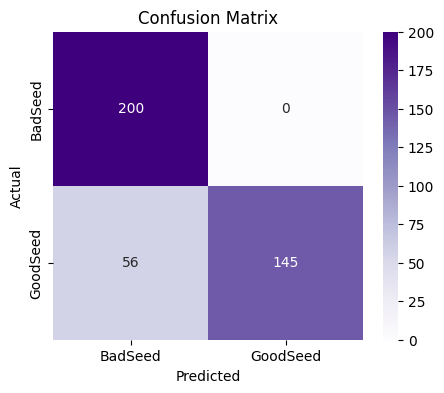

Evaluating on validation set (Rotate=15):
Accuracy: 0.830
Precision: 0.993
Recall: 0.667
F1 Score: 0.798
AUC Score: 0.961


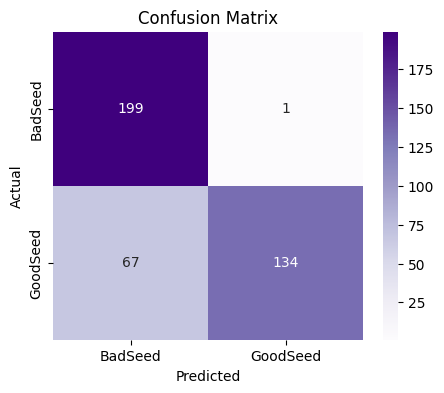

Evaluating on validation set (Rotate=30):
Accuracy: 0.830
Precision: 0.993
Recall: 0.667
F1 Score: 0.798
AUC Score: 0.961


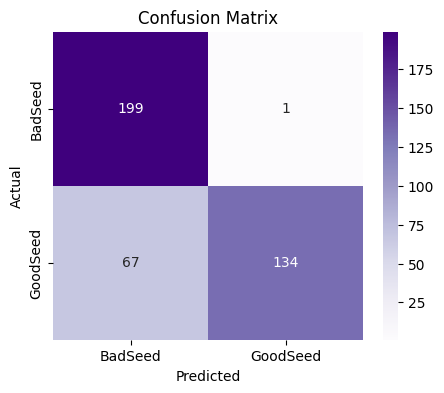

Evaluating on validation set (Rotate=45):
Accuracy: 0.840
Precision: 0.979
Recall: 0.697
F1 Score: 0.814
AUC Score: 0.965


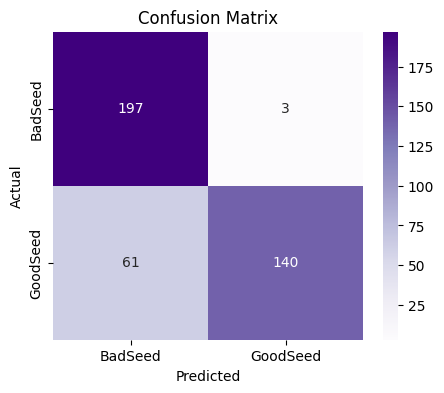

Evaluating on validation set (Rotate=90):
Accuracy: 0.850
Precision: 1.000
Recall: 0.701
F1 Score: 0.825
AUC Score: 0.968


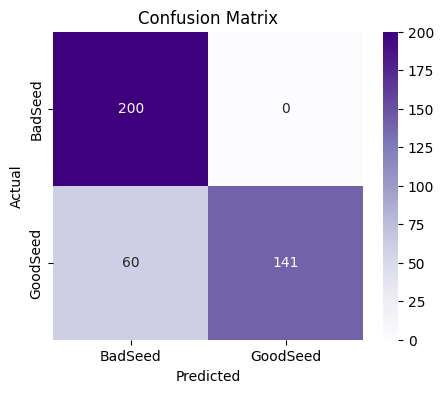

Evaluating on validation set (Rotate=180):
Accuracy: 0.848
Precision: 0.993
Recall: 0.701
F1 Score: 0.822
AUC Score: 0.967


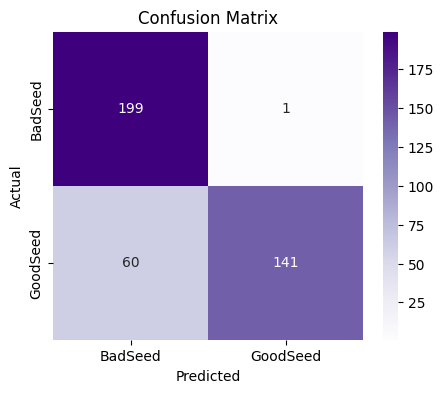

Evaluating on validation set (Rotate=360):
Accuracy: 0.845
Precision: 0.973
Recall: 0.711
F1 Score: 0.822
AUC Score: 0.963


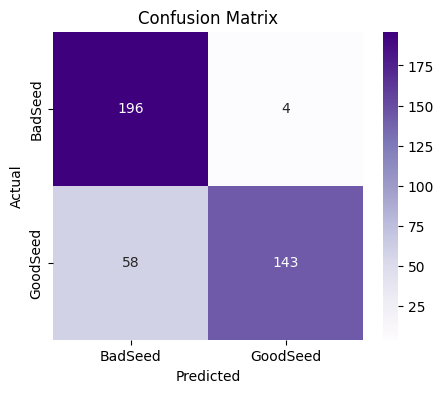

Evaluating on validation set (Translate=0.1):
Accuracy: 0.813
Precision: 0.992
Recall: 0.632
F1 Score: 0.772
AUC Score: 0.963


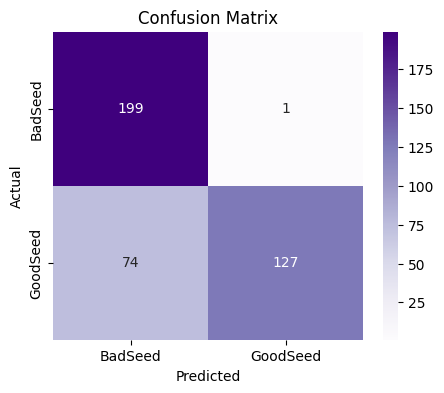

Evaluating on validation set (Translate=0.2):
Accuracy: 0.825
Precision: 0.985
Recall: 0.662
F1 Score: 0.792
AUC Score: 0.962


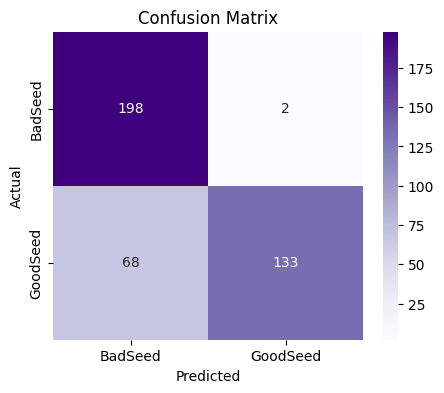

Evaluating on validation set (Translate=0.3):
Accuracy: 0.843
Precision: 0.973
Recall: 0.706
F1 Score: 0.818
AUC Score: 0.955


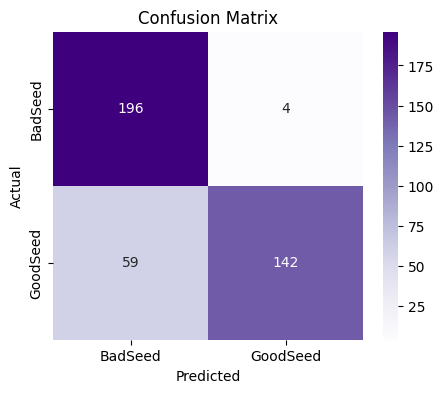

Evaluation results saved to CSV file.


In [6]:
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

# Define the transformations and corresponding labels
transformations = [
    (transform_brightness0_5, "Brightness=0.5"),
    (transform_brightness1_5, "Brightness=1.5"),
    (transform_noise0_01, "Noise=0.01"),
    (transform_noise0_05, "Noise=0.05"),
    (transform_noise0_1, "Noise=0.1"),
    (transform_scale0_8, "Scale=0.8"),
    (transform_scale1_2, "Scale=1.2"),
    (transform_scale1_5, "Scale=1.5"),
    (transform_rotate15, "Rotate=15"),
    (transform_rotate30, "Rotate=30"),
    (transform_rotate45, "Rotate=45"),
    (transform_rotate90, "Rotate=90"),
    (transform_rotate180, "Rotate=180"),
    (transform_rotate360, "Rotate=360"),
    (transform_translate0_1, "Translate=0.1"),
    (transform_translate0_2, "Translate=0.2"),
    (transform_translate0_3, "Translate=0.3")
]

metrics_dict = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
}

for transform, label in transformations:
    val_dataset = ImageFolder(root=val_dir, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    print(f"Evaluating on validation set ({label}):")

    acc, prec, rec, f1, auc = evaluate_model(model, val_loader, val_dataset)
    metrics_dict[label] = [acc, prec, rec, f1, auc]

metrics_df = pd.DataFrame(metrics_dict)

metrics_df.to_csv("/content/drive/MyDrive/Computer Vision Coursework/results/evaluation_results_modified_model.csv", index=False)

print("Evaluation results saved to CSV file.")

del model
torch.cuda.empty_cache()

tsne plots

## **Features Visualisation Across Different Layers**
The following cell outputs the representation of the features at different layers of the model i.e. *conv1, inception3a, inception3b, inception4a, inception4c, inception5a, inception5b, avgpool*. This visualisation is used to discuss the results of Requirement 4.

Extracting Features: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


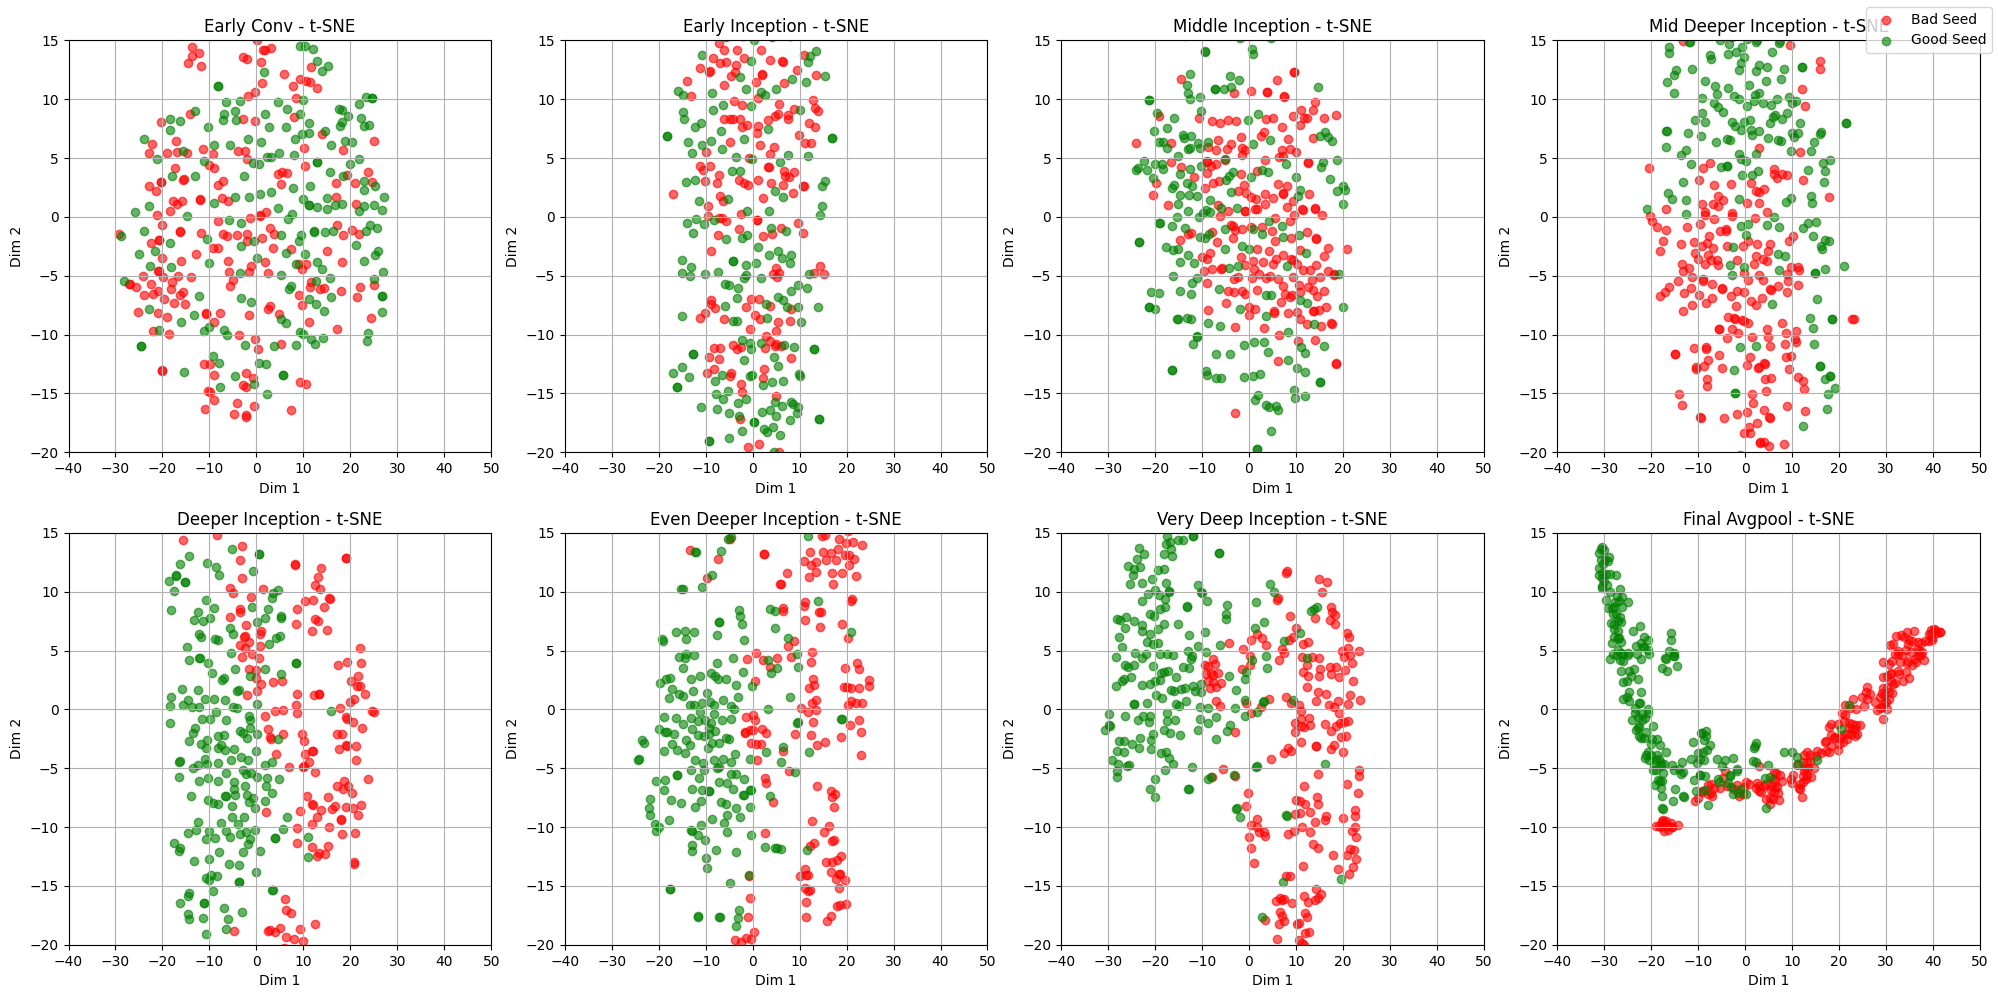

In [7]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet


# dictionary to store the feature maps
feature_maps = {}

def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = googlenet(weights=None, aux_logits=False, init_weights=True)
model.fc = nn.Linear(1024, 2)  # modify classifier for 2 output classes

state_dict = torch.load("/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_trained_with_aug_modifications_batch1.pth")
model.load_state_dict(state_dict)

#select layers to hook
layers_to_hook = {
    'early_conv': model.conv1,
    'early_inception': model.inception3a,
    'middle_inception': model.inception3b,
    'mid_deeper_inception': model.inception4a,
    'deeper_inception': model.inception4c,
    'even_deeper_inception': model.inception5a,
    'very_deep_inception': model.inception5b,
    'final_avgpool': model.avgpool,
}

#attach hooks
for name, layer in layers_to_hook.items():
    layer.register_forward_hook(get_activation(name))

#remove the final classification layer for feature extraction
model.fc = nn.Identity()
model.to(device).eval()

val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

# extracted from FinalNotebook1.ipynb
mean = [0.5035, 0.5035, 0.4966]
std = [0.2686, 0.2735, 0.2766]

original_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_dataset = ImageFolder(root=val_dir, transform=original_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

all_features = {name: [] for name in layers_to_hook.keys()}
all_labels = []

#disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Extracting Features"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        #store features from hooked layers
        for name in layers_to_hook.keys():
            feats = feature_maps[name]
            feats = feats.view(feats.size(0), -1)
            all_features[name].append(feats.cpu())

        all_labels.append(labels.cpu())

#concatenate across batches
for name in all_features.keys():
    all_features[name] = torch.cat(all_features[name], dim=0)
all_labels = torch.cat(all_labels, dim=0)

#run t-SNE and plot

def plot_tsne(features, labels, title, ax):
    features = features.numpy()
    labels = labels.numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    good_indices = labels == 1
    bad_indices = labels == 0

    ax.scatter(features_2d[bad_indices, 0], features_2d[bad_indices, 1],
               c='red', label='Bad Seed', alpha=0.6)
    ax.scatter(features_2d[good_indices, 0], features_2d[good_indices, 1],
               c='green', label='Good Seed', alpha=0.6)
    ax.set_title(f"{title} - t-SNE")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.grid(True)
    ax.set_xlim(-40, 50)
    ax.set_ylim(-20, 15)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, features) in enumerate(all_features.items()):
    plot_tsne(features, all_labels, title=name.replace("_", " ").title(), ax=axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

del model
torch.cuda.empty_cache()